In [21]:
# !pip install torcheval
import pandas as pd
import numpy as np
from nfstream import NFStreamer, NFPlugin
from nfstream.flow import NFlow
import os
import seaborn as sns
import pandas as pd
from nfstream import NFStreamer, NFPlugin
from nfstream.flow import NFlow
import os
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.optim as optim
import copy
import torch

import torchvision
from torch.utils.data import Dataset, DataLoader
import intel_extension_for_pytorch as ipex
from sklearn.base import BaseEstimator,TransformerMixin
import matplotlib.pyplot as plt
import joblib
from sklearn.neighbors import KNeighborsClassifier

In [37]:
device = torch.device("xpu" if torch.xpu.is_available() else "cpu")
print(device)

torch.set_printoptions(sci_mode=False)
torch.autograd.set_detect_anomaly(True)

batch_size=24
ms_columns = [
    'bidirectional_duration_ms',
    'src2dst_duration_ms',
    'dst2src_duration_ms',
]
timestamps_columns = [
    'bidirectional_first_seen_ms',
    'bidirectional_last_seen_ms',
    'src2dst_first_seen_ms',
    'src2dst_last_seen_ms',
    'dst2src_first_seen_ms',
    'dst2src_last_seen_ms',
]
to_drop = [
    'bidirectional_first_seen_ms',
    'bidirectional_last_seen_ms',
    'src2dst_first_seen_ms',
    'src2dst_last_seen_ms',
    'dst2src_first_seen_ms',
    'dst2src_last_seen_ms',
    'src_ip', 'dst_ip', 
    'protocol', 'src_oui', 
    'ip_version', 'dst_oui', 
    'application_name', 'application_category_name', 
    'vlan_id', 'expiration_id', 
    'content_type', 'client_fingerprint', 
    'server_fingerprint', 'user_agent', 
    'requested_server_name', 'src_mac', 
    'dst_mac', 'application_is_guessed', 
    'application_confidence', 'tunnel_id', 'id'
]


xpu


## Define paths

In [38]:
path = os.path.abspath("") + '/../datasets/' 
graph_path = path + '../graphs/'
filename = 'encrypted-23-12.pcapng'
val_filename_negative = 'unencrypted/dump'
val_filename_positive = 'encrypted/encr2'
benign_path = path + 'classification/benign.pcap'
sql_inj_path = path + 'classification/sql_inj-27.pcap'
xss_path = path + 'classification/xss.pcapng'
ddos_path = path + 'classification/ddos'
portscan_path = path + 'classification/portscan/part'

In [23]:
class TimestampsToLog(BaseEstimator, TransformerMixin):
    def __init__(self, column_names):
        self.column_names = column_names
            
    def fit(self, X, y = None):
        return self
    
    def transform(self, X, y = None):
        X_tmp = X.copy()
        cols = X_tmp.columns.to_list()
        
        for column in self.column_names:
            value = X_tmp[column]
            X_tmp[column] = X_tmp[column].apply(lambda x: 1 if x ==1 else (-1 if x ==0 else np.log(x).astype(float)))
        return X_tmp


In [24]:
class DropExcessCols(BaseEstimator, TransformerMixin):
    def __init__(self, to_drop):
        self.to_drop = to_drop
            
    def fit(self, X, y = None):
        return self
    
    def transform(self, X, y = None):
        X_tmp = X.copy()
        X_tmp = X_tmp.drop(columns=self.to_drop)
        return X_tmp

## NFPlugin to extract payload bytes distribution

In [35]:
import collections
bytes_distro = []
class PayloadCollector(NFPlugin):
    @staticmethod
    def _extend_flow_payload(packet, flow):
        if packet.payload_size > 0:
            payload = packet.ip_packet
            # flow.udps.payload_encodings.append(payload)
            byte_counter = collections.Counter(payload)
            flow.udps.payload_byte_distro += [byte_counter.get(byte, 0) for byte in range(256)]\

    def on_init(self, packet, flow):
        flow.udps.payload_byte_distro = np.zeros(256)
        # flow.udps.payload_encodings = []
        self._extend_flow_payload(packet, flow)

    def on_update(self, packet, flow):  
        self._extend_flow_payload(packet, flow)
    def on_expire(self, flow):
        flow.udps.payload_byte_distro = flow.udps.payload_byte_distro/max(1, sum(flow.udps.payload_byte_distro))

## Explore data

Now we will plot a heatmap of payload bytes distribution

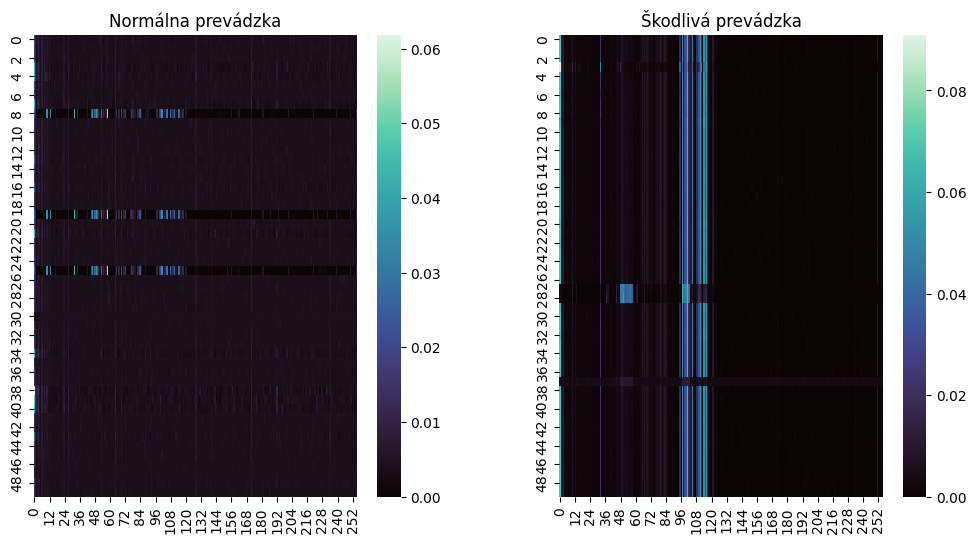

In [26]:
def get_distro(filename):
    streamer = NFStreamer(source=path+filename, udps=PayloadCollector())
    distro = []
    for flow in streamer:
        distro.append(flow.udps.payload_byte_distro)
    return np.array(distro)
def plot_distro(distro, ax):
    sns.heatmap(distro[100:150], cmap="mako", cbar=True, ax = ax)
encr_flows_distro = get_distro(filename)
plain_flows_distro = get_distro('classification/sql-injection.pcap')
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
fig.subplots_adjust(wspace=0.3)
ax[0].set_title('Normálna prevádzka')
ax[1].set_title('Škodlivá prevádzka')

plot_distro(encr_flows_distro, ax=ax[0])
plot_distro(plain_flows_distro, ax=ax[1])
fig.show()

## Metadata dataset class
Accepts preprocessed numpy array and converts it to tensors. 
Output: tensor of shape __N of flows, 1, 74__

In [27]:
class FlowDataset(Dataset):
  def __init__(self, flows, transforms = None):
    self.flows = flows
    self.transform = transforms
    self.flows = torch.tensor(self.flows).unsqueeze(1)

  def __getitem__(self, idx):
      sample = self.flows[idx]
      if self.transform:
            sample = self.transform(sample)
      return sample

  def __len__(self):
    return len(self.flows)


In [28]:
class AppendPayloadDistro(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y = None):
        return self
    def transform(self, X, y = None):
        X_temp = X.copy()
    
        columns = ['byte_' + str(i) for i in range(256)]
        distro = []
        distros = X_temp['udps.payload_byte_distro']
        
        for d in distros:
            values = d.strip('[]').split()
            distro.append(list(map(float, values)))
    
        X_temp = X_temp.drop(columns = ['udps.payload_byte_distro'])

        distro_df = pd.DataFrame(distro, columns = columns)
        
        return pd.concat([X_temp.reset_index(drop=True), distro_df], axis=1)

## Assigning datasets

__flow_df__ - flow-based properties - 63 features
__packet_df__ - packet-based payload bytes distribution - 256 features

In [39]:
batch_size = 32
columns = [
       'bidirectional_duration_ms', 'bidirectional_packets',
       'bidirectional_bytes', 
       'src2dst_duration_ms', 'src2dst_packets', 'src2dst_bytes',
        'dst2src_duration_ms', 'src_port', 'dst_port', 
       'dst2src_packets', 'dst2src_bytes', 'bidirectional_min_ps',
       'bidirectional_mean_ps', 'bidirectional_stddev_ps',
       'bidirectional_max_ps', 'src2dst_min_ps', 'src2dst_mean_ps',
       'src2dst_stddev_ps', 'src2dst_max_ps', 'dst2src_min_ps',
       'dst2src_mean_ps', 'dst2src_stddev_ps', 'dst2src_max_ps',
       'bidirectional_min_piat_ms', 'bidirectional_mean_piat_ms',
       'bidirectional_stddev_piat_ms', 'bidirectional_max_piat_ms',
       'src2dst_min_piat_ms', 'src2dst_mean_piat_ms', 'src2dst_stddev_piat_ms',
       'src2dst_max_piat_ms', 'dst2src_min_piat_ms', 'dst2src_mean_piat_ms',
       'dst2src_stddev_piat_ms', 'dst2src_max_piat_ms',
       'bidirectional_syn_packets', 'bidirectional_cwr_packets',
       'bidirectional_ece_packets', 'bidirectional_urg_packets',
       'bidirectional_ack_packets', 'bidirectional_psh_packets',
       'bidirectional_rst_packets', 'bidirectional_fin_packets',
       'src2dst_syn_packets', 'src2dst_cwr_packets', 'src2dst_ece_packets',
       'src2dst_urg_packets', 'src2dst_ack_packets', 'src2dst_psh_packets',
       'src2dst_rst_packets', 'src2dst_fin_packets', 'dst2src_syn_packets',
       'dst2src_cwr_packets', 'dst2src_ece_packets', 'dst2src_urg_packets',
       'dst2src_ack_packets', 'dst2src_psh_packets', 'dst2src_rst_packets',
       'dst2src_fin_packets']
pipeline = Pipeline(steps= [
        ('dropper', DropExcessCols(to_drop)),
        ('time_to_log', TimestampsToLog(ms_columns)),
        ('distro', AppendPayloadDistro()),
        ('scaler', MinMaxScaler())
    ])
def preprocess(filename, pipeline, fit=False):
    streamer = NFStreamer(source = filename, statistical_analysis=True, udps = PayloadCollector())
    flows = streamer.to_pandas()
    
    flows = flows[flows['ip_version'] == 4]
    if fit: pipeline = pipeline.fit(flows)
    
    return pipeline.transform(flows)

flow_train_df = preprocess(path + filename, pipeline, True)
flow_val_df_positive = preprocess(path+val_filename_positive, pipeline, False)
flow_val_df_negative = preprocess(sql_inj_path, pipeline, False)

flow_train_dataset = FlowDataset(flow_train_df)
flow_val_dataset_positive = FlowDataset(flow_val_df_positive)
flow_val_dataset_negative = FlowDataset(flow_val_df_negative)

flow_train_loader = DataLoader(flow_train_dataset, batch_size=batch_size)
flow_val_loader_positive = DataLoader(flow_val_dataset_positive, batch_size=batch_size)
flow_val_loader_negative = DataLoader(flow_val_dataset_negative, batch_size=batch_size)

In [40]:
flow_input_dim = flow_train_df.shape[1]

print(f'Total samples train: {len(flow_train_df)}')
print(f'Total samples val_positive: {len(flow_val_df_positive)}')
print(f'Total samples val_negative: {len(flow_val_df_negative)}')
print(f'Flow input dim: {flow_input_dim}')

print(f'Total batches train: {len(flow_train_loader)}')
print(f'Total batches val positive: {len(flow_val_loader_positive)}')
print(f'Total batches val negative: {len(flow_val_loader_negative)}')
print(f'Flow train loader batch shape: {next(iter(flow_train_loader)).shape}')

Total samples train: 3217
Total samples val_positive: 1043
Total samples val_negative: 9
Flow input dim: 315
Total batches train: 101
Total batches val positive: 33
Total batches val negative: 1
Flow train loader batch shape: torch.Size([32, 1, 315])


## Plot benign and sql injection vectors

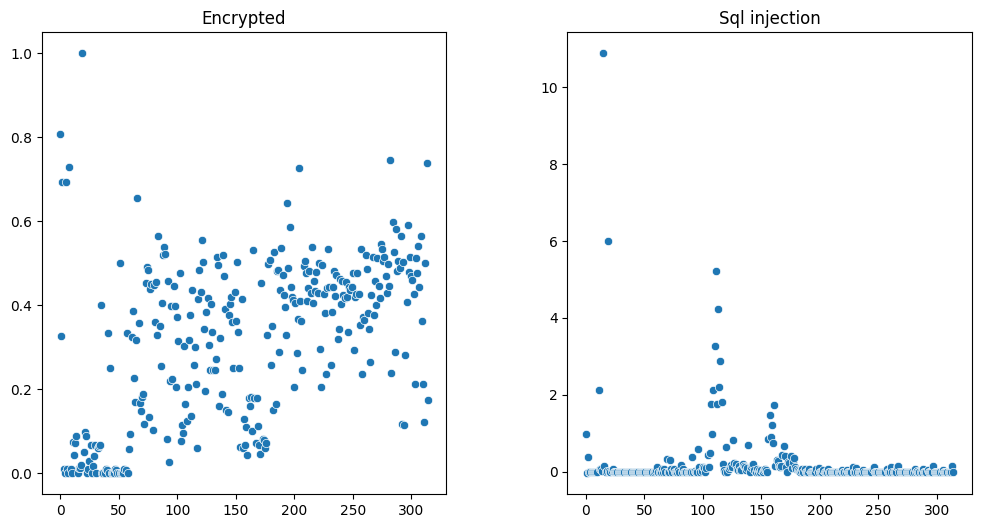

In [45]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
fig.subplots_adjust(wspace=0.3)
ax[0].set_title('Encrypted')
ax[1].set_title('Sql injection')

sns.scatterplot(flow_val_dataset_positive[0][0], ax = ax[0])
sns.scatterplot(flow_val_dataset_negative[0][0], ax = ax[1])

fig.show()


In [339]:
joblib.dump(pipeline, 'ae_pipeline_final.gz')

['ae_pipeline_final.gz']

## LSTM based autoencoder
The Autoencoder has Encoder and Decoder layers

In [151]:
class Encoder(nn.Module):
    def __init__(self, num_layers, hidden_size, nb_feature, dropout = 0, device = 'cpu'):
        super(Encoder, self).__init__()
        self.device = device
        self.input_size = nb_feature
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size = nb_feature, hidden_size = hidden_size, num_layers = num_layers, batch_first = True, dropout = dropout, bias = True).to(device)

    def initHidden(self, batch_size):
        self.hidden_cell = (
            torch.randn((self.num_layers, batch_size, self.hidden_size), dtype=torch.float).to(self.device),
            torch.randn((self.num_layers, batch_size, self.hidden_size), dtype=torch.float).to(self.device)
        )
    def forward(self, input_seq):
        self.initHidden(input_seq.shape[0])
        _, self.hidden_cell = self.lstm(input_seq, self.hidden_cell)
        return self.hidden_cell
        
class Decoder(nn.Module):
    def __init__(self, num_layers, hidden_size, nb_feature, dropout=0, device=torch.device('cpu')):
        super(Decoder, self).__init__()

        self.input_size = nb_feature
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.device = device
        self.lstm = nn.LSTM(input_size=nb_feature, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True, dropout=dropout, bias=True).to(device)
        self.linear = nn.Linear(in_features=hidden_size, out_features=nb_feature).to(device)

    def forward(self, input_seq, hidden_cell):
        output, hidden_cell = self.lstm(input_seq, hidden_cell)
        output = self.linear(output)
        return output, hidden_cell
        
class LSTMAutoEncoder(nn.Module):
    def __init__(self, num_layers, hidden_size, nb_feature, dropout=0, device=torch.device('cpu')):
        super(LSTMAutoEncoder, self).__init__()
        self.device = device
        self.encoder = Encoder(num_layers, hidden_size, nb_feature, dropout, device).to(device)
        self.decoder = Decoder(num_layers, hidden_size, nb_feature, dropout, device).to(device)

    def forward(self, input_seq):
        output = torch.zeros(size=input_seq.shape, dtype=torch.float).to(self.device)
        hidden_cell = self.encoder(input_seq)
        input_decoder = input_seq[:, -1, :].view(input_seq.shape[0], 1, input_seq.shape[2])
        for i in range(input_seq.shape[1] - 1, -1, -1):
            output_decoder, hidden_cell = self.decoder(input_decoder, hidden_cell)
            input_decoder = output_decoder
            output[:, i, :] = output_decoder[:, 0, :]
        return output

## Custom R2 function

In [152]:
def r2_score(y_true, y_pred):
    assert y_true.shape == y_pred.shape, "y_true and y_pred must have the same shape"

    y_mean = torch.mean(y_true)

    ss_res = torch.sum((y_true - y_pred) ** 2)
    ss_tot = torch.sum((y_true - y_mean) ** 2)
    
    r2 = 1 - ss_res / (ss_tot + 1e-8) 
    
    return r2.item()


## Training loop
- Loss should go down
- R2 should go up
- validation_loss_positive should go down (model performance on "unseen" encrypted flows)
- validation_loss_negative should stay high as we validate on unencrypted payload

In [165]:
epochs = 50
learning_rate = 1e-4

criterion = nn.MSELoss().to(device)

def train_one_epoch(model, loader, optimizer, val = False):
    running_loss = 0.
    r2 = []
    for i, batch in enumerate(loader):
        inputs = batch.float().permute(1, 0, 2).to(device)
        if not val: 
            optimizer.zero_grad() 
        outputs = model(inputs)
        loss = criterion(outputs, inputs)
        if not val:
            loss.backward() 
            optimizer.step()
        running_loss += loss.item()
        
        r2.append(r2_score(inputs, outputs))
    running_loss = running_loss / len(loader)
    r2 = np.array(r2)
    return running_loss, np.mean(r2)

def training_loop(model, train_loader, val_loader_positive, val_loader_negative, history, epochs = 50):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    print('Epoch | train_loss | val_loss_positive | val_loss_negative | R2 train | R2 val')
    for epoch in range(epochs):
        model.train()
        training_loss, r2_train = train_one_epoch(model, train_loader, optimizer)
        model.eval() 
        val_loss = []
        with torch.no_grad(): 
            val_loss_negative, _ = train_one_epoch(model, val_loader_negative, optimizer, val = True)
            val_loss_positive, r2_val = train_one_epoch(model, val_loader_positive, optimizer, val = True)
        history.append({'loss': training_loss, 'r2_train': r2_train, 'r2_val': r2_val, 'val_loss_negavtive': val_loss_negative, 'val_loss_positive': val_loss_positive})
        print(f'{epoch + 1} | {training_loss} | {val_loss_positive} | {val_loss_negative} | {r2_train} | {r2_val}')
    return history

## Train autoencoder

In [309]:
flow_ae = LSTMAutoEncoder(num_layers = 1, hidden_size = 20, nb_feature = flow_input_dim, device = device).to(device)
flow_history = []

In [310]:
training_loop(flow_ae,
              train_loader = flow_train_loader, 
              val_loader_positive = flow_val_loader_positive,
              val_loader_negative = flow_val_loader_negative,
              history = flow_history, 
              epochs = 90
             )

Epoch | train_loss | val_loss_positive | val_loss_negative | R2 train | R2 val
1 | 0.11371137340090232 | 0.08026294681158933 | 0.11426959410309792 | -2.146530923729171 | -1.2703250321474941
2 | 0.050056722461284994 | 0.024670829714247673 | 0.11999322026968003 | -0.38445893162024947 | 0.3021489598534324
3 | 0.016510149558816484 | 0.01053335207204024 | 0.12165683880448341 | 0.5454377300011184 | 0.7022212328332843
4 | 0.01009331112671755 | 0.008568853915979465 | 0.1227960579097271 | 0.7234887277294776 | 0.7578408934853293
5 | 0.0091490170076311 | 0.008279176922797254 | 0.12327680066227913 | 0.7496898895252251 | 0.7660438526760448
6 | 0.008981965250798507 | 0.008233981588008728 | 0.12338286191225052 | 0.7543200272286009 | 0.7673235607869697
7 | 0.008948335488198582 | 0.008230587566327868 | 0.12337769269943237 | 0.7552495024161424 | 0.7674188884821805
8 | 0.008940417021178378 | 0.008232667717631117 | 0.12337453737854957 | 0.7554667877579877 | 0.7673587311397899


KeyboardInterrupt: 

In [311]:
with open('ae_train.npy', 'wb') as f:
    np.save(f, flow_history)

In [250]:
history_df = pd.DataFrame(flow_history)
history_df.to_csv('flow_history.csv', sep='\t')

## Plotting loss 
After trying training on small subsets, we will now see how loss was changing and tweak model parameters

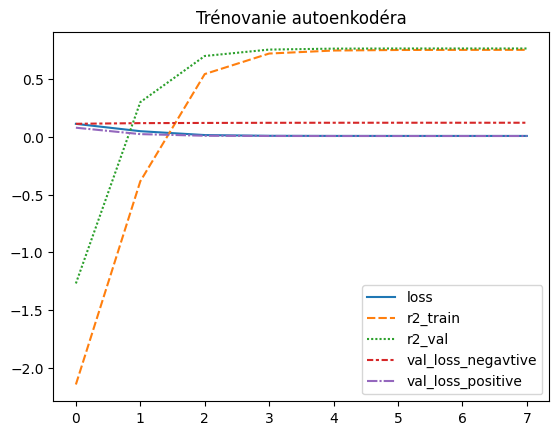

In [3]:
flow_history = np.load('ae_train.npy', allow_pickle=True)
stats = pd.DataFrame(list(flow_history))
sns.lineplot(stats).set_title("Trénovanie autoenkodéra")
plt.savefig('flow_ae_final.png')

In [338]:
torch.save(flow_ae, path + 'ae_final.pth')